# Task: Riconoscimento automatico di una review positiva o negativa;

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

## Get reviews dataset

In [204]:
df_review = pd.read_csv('./dataset/review_dropped.csv')

In [205]:
# review_id // string, 22 character unique review id
# user_id // string, 22 character unique user id, maps to the user in user.json
# business_id // string, 22 character business id, maps to business in business.json
# stars // integer, star rating
# date // string, date formatted YYYY-MM-DD
# text // string, the review itself
# useful // integer, number of useful votes received by review
# funny // integer, number of funny votes received by review
# cool // integer, number of cool votes received by review

In [206]:
# Drop some rows in order to increment performances

# df_review = df_review.iloc[460000:, :]
df_review = df_review.iloc[499000:, :]
df_review = df_review.reset_index()

df_review.head(5)

,level_0,Unnamed: 0,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,499000,499000,6989282,NIukhO8BR2wACBztNSRDbQ,Ta9o6-WIRDn5KDvZy8XPNA,jMStvE-tQzSpRCAO0nAE6g,1.0,0.0,0.0,0.0,"Do not eat there! Horrible management, staff a...",2019-05-16 03:34:49
1,499001,499001,6989283,H_-EZhZAZqginAR8EkKxIw,k0qcNly5aTjjr__iNdPKBw,beSgKHecMsEyz6iy7gm-9w,5.0,0.0,0.0,0.0,What a great find! Celebrated out anniversary ...,2021-05-17 01:19:06
2,499002,499002,6989284,aeNMLPf1XGedxQLyTwS8Bg,_0EhXpz__Bs5qNckMW8IEw,Meww6RIE4cFL_kG0aRlbAA,5.0,2.0,0.0,1.0,Great happy hour & great food. I had a great t...,2021-05-09 11:23:03
3,499003,499003,6989285,oDrDjpgNDUXAmrYWU6Q1bQ,tfxcBBdKo28s6OAYNJDM6A,mY4i1N0Hm2fjIgU0Eyn11Q,1.0,2.0,0.0,0.0,"I've been dining here for years, but a recent ...",2021-05-17 22:45:45
4,499004,499004,6989286,jbSsvlNW1VGc-o8b3WBjDw,q6CU8yNwSs2ErfhX3DqaNQ,GxlUXBXe-yw6B5Fqf8kgig,3.0,2.0,1.0,1.0,Food was pretty good. Had the southern fried c...,2016-09-19 23:52:02


### Add boolean positive_review to dataset in order to recognize positive review (>= 4 stars)


In [207]:
df_review['review_rating'] = np.where(df_review['stars'] >= 4, 1, 0)

df_review.head(5)


,level_0,Unnamed: 0,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_rating
0,499000,499000,6989282,NIukhO8BR2wACBztNSRDbQ,Ta9o6-WIRDn5KDvZy8XPNA,jMStvE-tQzSpRCAO0nAE6g,1.0,0.0,0.0,0.0,"Do not eat there! Horrible management, staff a...",2019-05-16 03:34:49,0
1,499001,499001,6989283,H_-EZhZAZqginAR8EkKxIw,k0qcNly5aTjjr__iNdPKBw,beSgKHecMsEyz6iy7gm-9w,5.0,0.0,0.0,0.0,What a great find! Celebrated out anniversary ...,2021-05-17 01:19:06,1
2,499002,499002,6989284,aeNMLPf1XGedxQLyTwS8Bg,_0EhXpz__Bs5qNckMW8IEw,Meww6RIE4cFL_kG0aRlbAA,5.0,2.0,0.0,1.0,Great happy hour & great food. I had a great t...,2021-05-09 11:23:03,1
3,499003,499003,6989285,oDrDjpgNDUXAmrYWU6Q1bQ,tfxcBBdKo28s6OAYNJDM6A,mY4i1N0Hm2fjIgU0Eyn11Q,1.0,2.0,0.0,0.0,"I've been dining here for years, but a recent ...",2021-05-17 22:45:45,0
4,499004,499004,6989286,jbSsvlNW1VGc-o8b3WBjDw,q6CU8yNwSs2ErfhX3DqaNQ,GxlUXBXe-yw6B5Fqf8kgig,3.0,2.0,1.0,1.0,Food was pretty good. Had the southern fried c...,2016-09-19 23:52:02,0


### Plot reviews

Positive reviews: 653
Negative reviews: 347


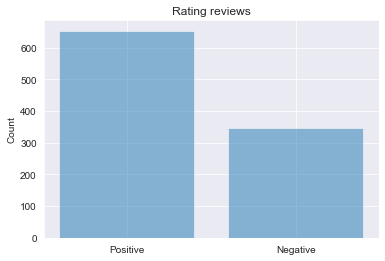

In [208]:
positive_count = (df_review['review_rating'] == 1).sum()
negative_count = (df_review['review_rating'] == 0).sum()

print("Positive reviews:", positive_count)

print("Negative reviews:", negative_count)

objects = ('Positive', 'Negative')
performance = [positive_count, negative_count]
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Rating reviews')

plt.show()



# Text preprocessing


In [209]:
import nltk
import contractions
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
# from nltk.corpus import stopwords
# nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [210]:
df_review_text_rating = df_review[['text', 'review_rating']].copy()

## Normalization

### Expand English contractions

In [211]:
def expand_english_contractions(data_frame):

    def expand(row):
        expanded_words = []
        for word in row['text'].split():
            expanded_words.append(contractions.fix(word))
        return ' '.join(expanded_words)

    data_frame['expanded_text'] = data_frame.apply(expand, axis=1)

## Tokenize

In [212]:
def tokenize_text(data_frame):

    def tokenize(row):
        return word_tokenize(row['expanded_text'])

    data_frame['tokenized_text'] = data_frame.apply(tokenize, axis=1)

## Remove puncts

In [213]:
def remove_punct_from_text(data_frame):

    def remove_punct(row):
        return [word for word in row['tokenized_text'] if word.isalpha()]

    data_frame['no_punct_text'] = data_frame.apply(remove_punct, axis=1)

## Stemming

In [214]:
def stem_text(data_frame):

    ps = PorterStemmer()
    def stemming(row):
        return [ps.stem(word) for word in row['no_punct_text']]

    data_frame['stemmed_text'] = data_frame.apply(stemming, axis=1)

## Lemmatization

In [215]:
def lemm_text(data_frame):

    lemmatizer = WordNetLemmatizer()
    def lemmatization(row):
        return [lemmatizer.lemmatize(word) for word in row['stemmed_text']]

    data_frame['lemmatized_text'] = data_frame.apply(lemmatization, axis=1)

## Remove stopwords

In [216]:
# def stop_word_text(data_frame):

#     def remove_stopwords(row):
#       return [word for word in row['lemmatized_text'] if not word in stopwords.words()]
#
#     data_frame['no_stopwords'] = data_frame.apply(remove_stopwords, axis=1)

## Rejoin words after processing

In [217]:
def rejoin_sentences(data_frame):
    def join_words(row):
        return " ".join(row['lemmatized_text'])

    data_frame['processed_text'] = data_frame.apply(join_words, axis=1)

## Process Text

In [218]:
def process_text(data_frame):
    expand_english_contractions(data_frame)
    tokenize_text(data_frame)
    remove_punct_from_text(data_frame)
    stem_text(data_frame)
    lemm_text(data_frame)
    rejoin_sentences(data_frame)

In [219]:
process_text(df_review_text_rating)
df_review_text_rating.head(5)

,text,review_rating,expanded_text,tokenized_text,no_punct_text,stemmed_text,lemmatized_text,processed_text
0,"Do not eat there! Horrible management, staff a...",0,"Do not eat there! Horrible management, staff a...","[Do, not, eat, there, !, Horrible, management,...","[Do, not, eat, there, Horrible, management, st...","[do, not, eat, there, horribl, manag, staff, a...","[do, not, eat, there, horribl, manag, staff, a...",do not eat there horribl manag staff and food ...
1,What a great find! Celebrated out anniversary ...,1,What a great find! Celebrated out anniversary ...,"[What, a, great, find, !, Celebrated, out, ann...","[What, a, great, find, Celebrated, out, annive...","[what, a, great, find, celebr, out, anniversar...","[what, a, great, find, celebr, out, anniversar...",what a great find celebr out anniversari and t...
2,Great happy hour & great food. I had a great t...,1,Great happy hour & great food. I had a great t...,"[Great, happy, hour, &, great, food, ., I, had...","[Great, happy, hour, great, food, I, had, a, g...","[great, happi, hour, great, food, i, had, a, g...","[great, happi, hour, great, food, i, had, a, g...",great happi hour great food i had a great time...
3,"I've been dining here for years, but a recent ...",0,"I have been dining here for years, but a recen...","[I, have, been, dining, here, for, years, ,, b...","[I, have, been, dining, here, for, years, but,...","[i, have, been, dine, here, for, year, but, a,...","[i, have, been, dine, here, for, year, but, a,...",i have been dine here for year but a recent ho...
4,Food was pretty good. Had the southern fried c...,0,Food was pretty good. Had the southern fried c...,"[Food, was, pretty, good, ., Had, the, souther...","[Food, was, pretty, good, Had, the, southern, ...","[food, wa, pretti, good, had, the, southern, f...","[food, wa, pretti, good, had, the, southern, f...",food wa pretti good had the southern fri chick...


# Split dataframe in training_set and test_set

In [220]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [221]:
X = df_review_text_rating["processed_text"]
y = df_review_text_rating["review_rating"]

# Training set = 80%
# Test set = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [222]:
# Initialize
vectorizer = TfidfVectorizer()
X_train_vectorizer = vectorizer.fit_transform(X_train)
X_test_vectorizer = vectorizer.transform(X_test)

X_train_df = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=X_train_vectorizer.toarray())
X_test_df = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=X_test_vectorizer.toarray())

In [223]:
X_train_df.head(5)

,abe,abid,abil,abita,abl,about,abov,abrupt,abruptli,absolut,...,zero,zest,zip,ziplock,zlt,zoal,zucchini,zumba,zushipok,ànd
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.072876,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
X_test_df.head(5)

,abe,abid,abil,abita,abl,about,abov,abrupt,abruptli,absolut,...,zero,zest,zip,ziplock,zlt,zoal,zucchini,zumba,zushipok,ànd
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.064824,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Algorithms

In [225]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from IPython.core.display_functions import display
import seaborn as sns

In [226]:
# Features as Array
# features = np.array(vectorizer.get_feature_names_out())

# array_X_train = X_train_vectorizer.toarray()
# array_X_test = X_test_vectorizer.toarray()

### Get best parameters

In [227]:
def get_best_parameters(algorithm, algorithm_parameters):
    gs_algorithm = GridSearchCV(algorithm, algorithm_parameters, verbose=3, scoring='f1', n_jobs=-1)

    gs_algorithm.fit(X_train_df, y_train)

    print(gs_algorithm.best_params_)

    # Find best model score
    print(gs_algorithm.score(X_train_df, y_train))

### Execute algorithm

In [228]:
def fit_and_predict(algorithm):

    # Training model
    algorithm.fit(X_train_df, y_train)

    # Predicting the test set results
    y_pred_algorithm = algorithm.predict(X_test_df)

    # Training score
    print(f"Score on training set: {algorithm.score(X_train_df, y_train)}")
    print(f"Score on test set: {algorithm.score(X_test_df, y_test)}")

    test_set_score = algorithm.score(X_test_df, y_test) * 100

    return y_pred_algorithm, test_set_score

### Confusion Matrix

In [229]:
def confusion_matrix_plot(algorithm_name, y_pred_algorithm):
    confusion_matrix_algorithm = confusion_matrix(y_test, y_pred_algorithm)
    df_confusion_matrix = pd.DataFrame(confusion_matrix_algorithm, columns=['Predicted 0', 'Predicted 1'],
                                           index=['True 0', 'True 1'])
    # display(df_confusion_matrix_gnb)

    sns.heatmap(df_confusion_matrix, annot=True, fmt='d')
    plt.title(algorithm_name + " confusion matrix")
    plt.figure(figsize=(24, 14), dpi=100)
    plt.close()

### Performance metrics

In [230]:
def classification_report_plot(algorithm_name, y_pred_algorithm):
    classification_report_algorithm = classification_report(y_test, y_pred_algorithm, output_dict=True)
    df_algorithm_report = pd.DataFrame(classification_report_algorithm).transpose()

    df_algorithm_report.iloc[:3, :3].plot(kind='bar', title= algorithm_name + 'classification report', rot=0)

    print(df_algorithm_report)

In [231]:
# return score, confusion matrix, classification report
def get_test_set_score(algorithm, algorithm_name, X_train_param, X_test_param):
    y_pred_algorithm, test_set_score_algorithm = fit_and_predict(algorithm)
    confusion_matrix_plot(algorithm_name, y_pred_algorithm)
    classification_report_plot(algorithm_name, y_pred_algorithm)
    return test_set_score_algorithm

## AdaBoostClassifier

In [232]:
ada_name = 'ADA'

In [233]:
# ada_parameters = {'n_estimators': [10, 50, 100, 250, 500],
#               'learning_rate': [0.01, 0.1],
#               'algorithm': ['SAMME', 'SAMME.R']}
#
# get_best_parameters(AdaBoostClassifier(), ada_parameters)


In [234]:
ada = AdaBoostClassifier(n_estimators=250, learning_rate=0.1, algorithm='SAMME.R')

y_pred_ada, test_set_score_ada = fit_and_predict(ada)

Score on training set: 0.955
Score on test set: 0.85


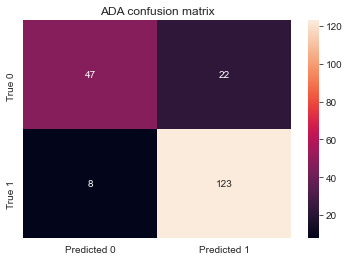

In [235]:
confusion_matrix_plot(ada_name, y_pred_ada)

              precision    recall  f1-score  support
0              0.854545  0.681159  0.758065    69.00
1              0.848276  0.938931  0.891304   131.00
accuracy       0.850000  0.850000  0.850000     0.85
macro avg      0.851411  0.810045  0.824684   200.00
weighted avg   0.850439  0.850000  0.845337   200.00


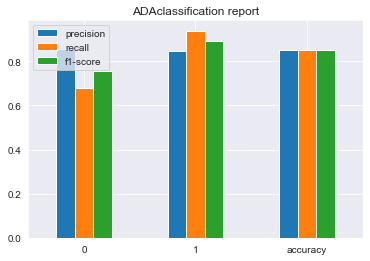

In [236]:
classification_report_plot(ada_name, y_pred_ada)

## GaussianNB

In [237]:
gnb_name = 'GNB'

In [238]:
# gnb_parameters = {'var_smoothing' : np.logspace(0,-9, num=100)}
#
# get_best_parameters(GaussianNB(), gnb_parameters)

In [239]:
gnb = GaussianNB(var_smoothing=0.0008111308307896872)

y_pred_gnb, test_set_score_gnb = fit_and_predict(gnb)


Score on training set: 0.985
Score on test set: 0.67


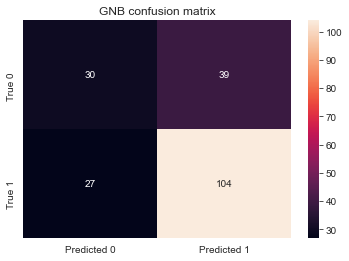

In [240]:
confusion_matrix_plot(gnb_name, y_pred_gnb)

              precision    recall  f1-score  support
0              0.526316  0.434783  0.476190    69.00
1              0.727273  0.793893  0.759124   131.00
accuracy       0.670000  0.670000  0.670000     0.67
macro avg      0.626794  0.614338  0.617657   200.00
weighted avg   0.657943  0.670000  0.661512   200.00


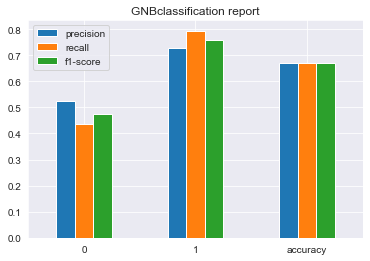

In [241]:
classification_report_plot(gnb_name, y_pred_gnb)

## DecisionTreeClassifier

In [242]:
dtc_name = 'DTC'

In [243]:
# dtc_parameters = {'splitter': ['best', 'random'],
#                   'max_features': ['auto', 'sqrt', 'log2', None],
#                   'random_state': [7, 42, 101]}
#
# get_best_parameters(DecisionTreeClassifier(), dtc_parameters)

In [244]:
dtc = DecisionTreeClassifier(splitter='random', max_features=None, random_state=7)

y_pred_dtc, test_set_score_dtc = fit_and_predict(dtc)


Score on training set: 1.0
Score on test set: 0.81


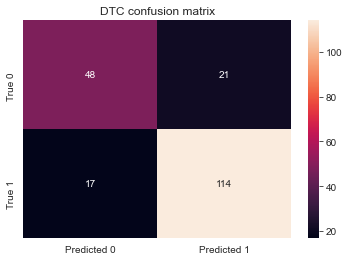

In [245]:
confusion_matrix_plot(dtc_name, y_pred_dtc)

              precision    recall  f1-score  support
0              0.738462  0.695652  0.716418    69.00
1              0.844444  0.870229  0.857143   131.00
accuracy       0.810000  0.810000  0.810000     0.81
macro avg      0.791453  0.782941  0.786780   200.00
weighted avg   0.807880  0.810000  0.808593   200.00


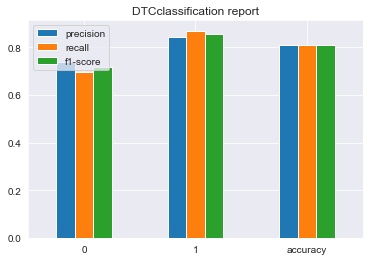

In [246]:
classification_report_plot(dtc_name, y_pred_dtc)

## LogisticRegression

In [247]:
lr_name = 'LR'

In [248]:
# lr_parameters = {'C': [0.001, 0.01, 0.1, 1.0],
#               'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
#               'random_state': [7, 42, 101]}
#
# get_best_parameters(LogisticRegression(), lr_parameters)

In [249]:
lr = LogisticRegression(C=1.0, solver='newton-cg', random_state=7)

y_pred_lr, test_set_score_lr = fit_and_predict(lr)

Score on training set: 0.91125
Score on test set: 0.81


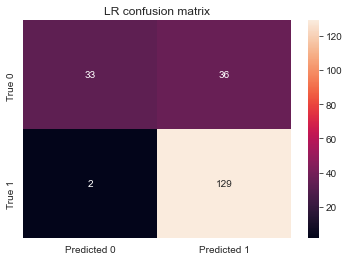

In [250]:
confusion_matrix_plot(lr_name, y_pred_lr)

              precision    recall  f1-score  support
0              0.942857  0.478261  0.634615    69.00
1              0.781818  0.984733  0.871622   131.00
accuracy       0.810000  0.810000  0.810000     0.81
macro avg      0.862338  0.731497  0.753119   200.00
weighted avg   0.837377  0.810000  0.789854   200.00


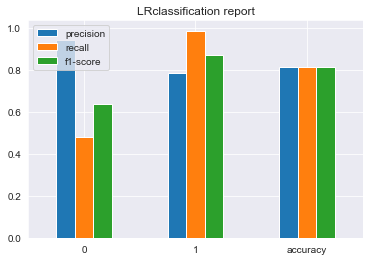

In [251]:
classification_report_plot(lr_name, y_pred_lr)

## KNeighborsClassifier

In [252]:
knc_name = 'KNC'

In [253]:
# knc_parameters = {'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
#               'algorithm': ['ball_tree']}
#
# get_best_parameters(KNeighborsClassifier(n_jobs=-1), knc_parameters)

In [254]:
knc = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=31, weights='uniform', n_jobs=-1)

y_pred_knc, test_set_score_knc = fit_and_predict(knc)

Score on training set: 0.80375
Score on test set: 0.75


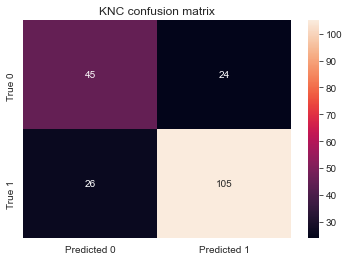

In [255]:
confusion_matrix_plot(knc_name, y_pred_knc)

              precision    recall  f1-score  support
0              0.633803  0.652174  0.642857    69.00
1              0.813953  0.801527  0.807692   131.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.723878  0.726850  0.725275   200.00
weighted avg   0.751802  0.750000  0.750824   200.00


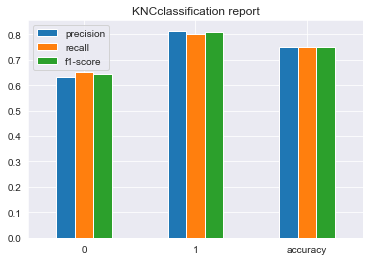

In [256]:
classification_report_plot(knc_name, y_pred_knc)

## Support Vector Machine

In [257]:
svc_name = 'SVC'

In [258]:
# svc_parameters = {'C': [0.001, 0.01, 0.1, 1.0],
#               'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
#               'decision_function_shape': ['ovo', 'ovr']}
#
# get_best_parameters(SVC(), svc_parameters)

In [259]:
svc = SVC(C=1.0, kernel='linear', decision_function_shape='ovo')

y_pred_svc, test_set_score_svc = fit_and_predict(svc)

Score on training set: 0.985
Score on test set: 0.87


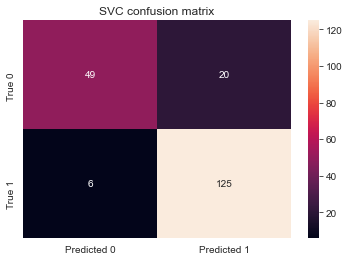

In [260]:
confusion_matrix_plot(svc_name, y_pred_svc)

              precision    recall  f1-score  support
0              0.890909  0.710145  0.790323    69.00
1              0.862069  0.954198  0.905797   131.00
accuracy       0.870000  0.870000  0.870000     0.87
macro avg      0.876489  0.832172  0.848060   200.00
weighted avg   0.872019  0.870000  0.865958   200.00


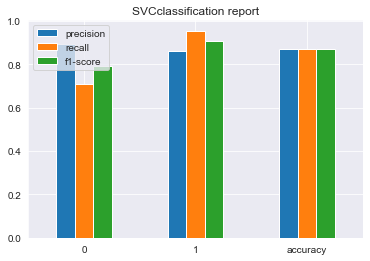

In [261]:
classification_report_plot(svc_name, y_pred_svc)

## RandomForestClassifier

In [262]:
rfc_name = 'RFC'

In [263]:
# rfc_parameters = {'n_estimators': [10, 50, 100, 250, 500],
#               'random_state': [7, 42, 101]}
#
# get_best_parameters(RandomForestClassifier(), rfc_parameters)

In [264]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

y_pred_rfc, test_set_score_rfc = fit_and_predict(rfc)

Score on training set: 1.0
Score on test set: 0.795


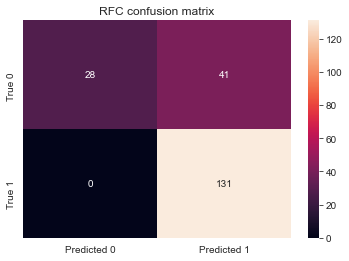

In [265]:
confusion_matrix_plot(rfc_name, y_pred_rfc)

              precision    recall  f1-score  support
0              1.000000  0.405797  0.577320   69.000
1              0.761628  1.000000  0.864686  131.000
accuracy       0.795000  0.795000  0.795000    0.795
macro avg      0.880814  0.702899  0.721003  200.000
weighted avg   0.843866  0.795000  0.765545  200.000


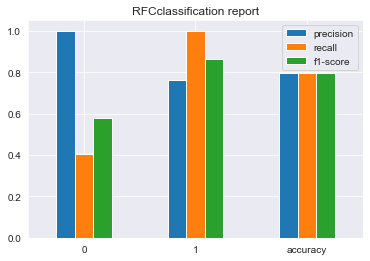

In [266]:
classification_report_plot(rfc_name, y_pred_rfc)

## Plot algorithm accuracy

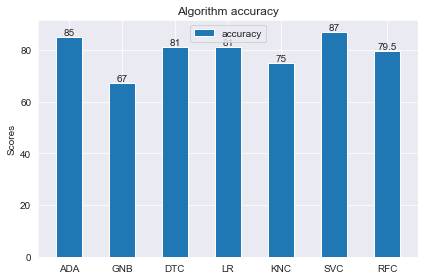

In [267]:
labels = [ada_name, gnb_name, dtc_name, lr_name, knc_name, svc_name, rfc_name]
score_values = [test_set_score_ada, test_set_score_gnb, test_set_score_dtc, test_set_score_lr, test_set_score_knc, test_set_score_svc, test_set_score_rfc]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the space between bar
width_bar = 0.50

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, score_values, width_bar, label='accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Algorithm accuracy')
ax.set_xticks(x - width/2, labels)
ax.legend()

ax.bar_label(rects1)

fig.tight_layout()

plt.show()

# Predict Review

In [268]:
def predict_review(review):
    df_final = pd.DataFrame([review], columns=['text'])
    process_text(df_final)

    vectorized_review = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data=vectorizer.transform(df_final["processed_text"]).toarray())

    review_prediction = svc.predict(vectorized_review)

    return review_prediction

In [269]:
print(predict_review("This restaurant is very very good and beautiful!"))

[1]
